In [25]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

data = pd.read_csv(r"face_similarity_scores(original_mtcnn+retina).csv")
data2 = pd.read_csv(r"face_similarity_scores(rgb,grayscale,increasing_contrast_mtcnn+retina).csv")
data3 = pd.read_csv(r"face_similarity_scores(rgb_to_bgr_mtcnn+retina).csv")
data4 = pd.read_csv(r"face_similarity_scores(image augmantation_mtcnn+retina).csv")

df = data.copy()
df2 = data2.copy()
df3 = data3.copy()
df4 = data4.copy()

In [2]:
df.head()

,case_no,facenet_score,arcface_score,facenet_label,arcface_label,lvface_label,lvface_score
0,1,0.7931,0.4748,1,0,1,0.5288
1,2,0.5635,0.4882,0,0,0,-0.0711
2,3,0.0972,0.1828,0,0,0,0.1025
3,4,0.8226,0.6481,1,1,0,-0.0503
4,5,0.4305,0.3766,0,0,0,-0.0155


In [3]:
df2.head()

,case_no,facenet_score,arcface_score,lvface_score,facenet_pred,arcface_pred,lvface_label
0,1,0.7844,0.5323,0.4878,1,0,1
1,2,0.7561,0.4401,0.5988,1,0,0
2,3,0.6682,0.4996,0.5199,1,0,0
3,4,0.4948,0.5602,0.6211,0,0,0
4,5,-0.0452,0.0316,0.4808,0,0,0


In [4]:
df3.head()

,case_no,facenet_score,arcface_score,lvface_score,facenet_pred,arcface_pred,lvface_label
0,1,0.9330,0.9000,0.5186,1,1,1
1,2,0.6528,0.6643,0.5652,1,1,0
2,3,0.7513,0.6485,0.5185,1,1,0
3,4,0.7060,0.4104,0.6933,1,0,0
4,5,0.6949,0.4680,0.4061,1,0,0


In [26]:
df4.head()

,case_no,facenet_score,arcface_score,lvface_score,facenet_pred,arcface_pred,lvface_label
0,1,0.6255,0.4411,0.6985,1,0,1
1,2,0.6064,0.4917,0.5912,1,0,0
2,3,0.6899,0.5043,0.6233,1,0,1
3,4,0.8103,0.7602,0.7535,1,1,1
4,5,0.4758,0.5168,0.5370,0,0,0


       facenet_score  arcface_score  lvface_score
count     100.000000     100.000000    100.000000
mean        0.357161       0.301261      0.232512
std         0.320983       0.242343      0.258663
min        -0.234800      -0.074800     -0.114300
25%         0.081650       0.093575      0.004075
50%         0.304550       0.191950      0.089800
75%         0.653875       0.511600      0.497525
max         0.908900       0.779600      0.707600

Distribusi label (setelah update):
Facenet: {1: 50, 0: 50}
ArcFace: {1: 50, 0: 50}
LVFace: {0: 56, 1: 44}


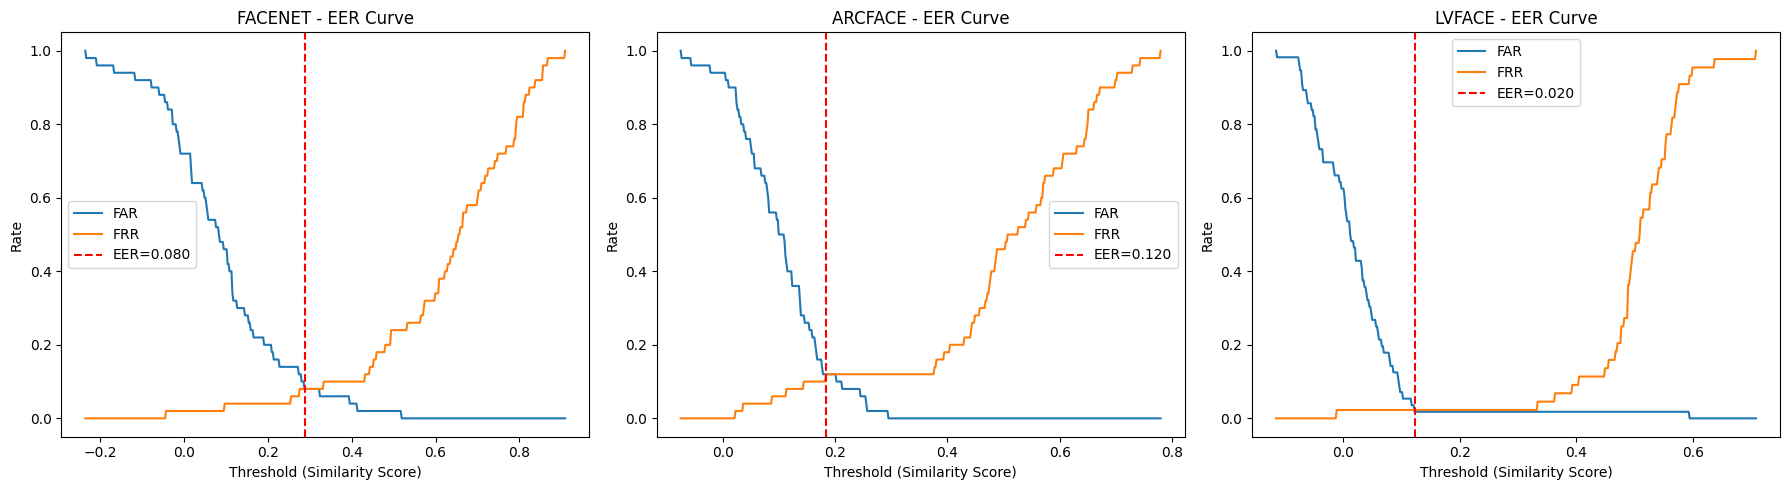

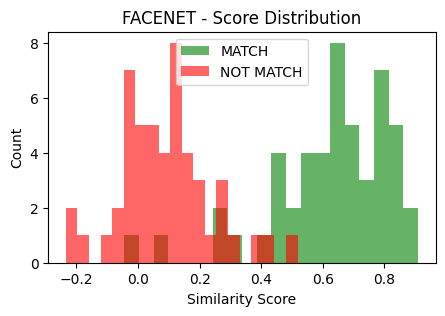

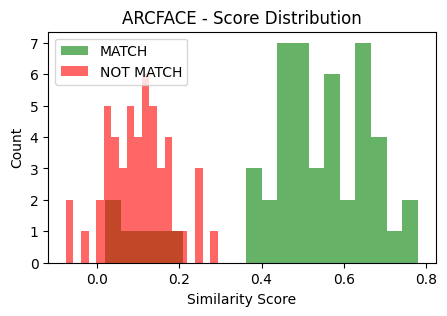

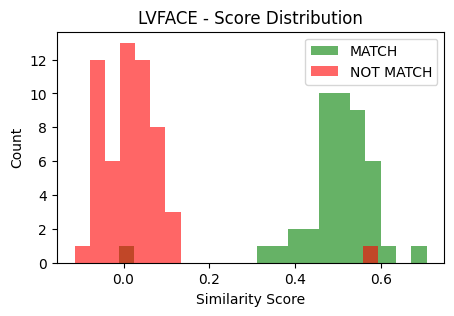


=== DEBUG SCORE RANGE ===
FACENET:
  MATCH mean: 0.6251
  NOT MATCH mean: 0.0893
  MATCH range: -0.0444 → 0.9089
  NOT MATCH range: -0.2348 → 0.5180

ARCFACE:
  MATCH mean: 0.4990
  NOT MATCH mean: 0.1035
  MATCH range: 0.0211 → 0.7796
  NOT MATCH range: -0.0748 → 0.2941

LVFACE:
  MATCH mean: 0.5007
  NOT MATCH mean: 0.0218
  MATCH range: -0.0112 → 0.7076
  NOT MATCH range: -0.1143 → 0.5931


=== HASIL AKHIR (FAR, FRR, EER) ===
     Model     EER  Threshold_EER  FAR@EER  FRR@EER Note
0  FACENET  0.0800         0.2878   0.0800   0.0800     
1  ARCFACE  0.1200         0.1837   0.1200   0.1200     
2   LVFACE  0.0203         0.1229   0.0179   0.0227     


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 1️⃣ Load dataset
# =========================
# Misal file CSV kamu sudah dibaca jadi DataFrame df
# Contoh: df = pd.read_csv("hasil_matching.csv")

# Pastikan kolom numerik
for col in ['facenet_score', 'arcface_score', 'lvface_score']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# =========================
# 2️⃣ Override label untuk Facenet & ArcFace (baris 1–50 = MATCH)
# =========================
df['facenet_label'] = 0
df.loc[:49, 'facenet_label'] = 1  # baris 1–50 dianggap MATCH

df['arcface_label'] = 0
df.loc[:49, 'arcface_label'] = 1  # baris 1–50 dianggap MATCH

# LVFace tidak diubah
# df['lvface_label'] tetap seperti aslinya

# =========================
# 3️⃣ Fungsi menghitung FAR, FRR, dan EER (Similarity-based)
# =========================
def compute_far_frr(scores, labels):
    """
    Menghitung FAR, FRR, dan EER untuk model similarity-based.
    Semakin besar score → semakin match.
    """
    eps = 1e-6
    thresholds = np.linspace(min(scores) - eps, max(scores) + eps, 500)
    fars, frrs = [], []

    total_neg = np.sum(labels == 0)  # NOT MATCH
    total_pos = np.sum(labels == 1)  # MATCH

    for th in thresholds:
        preds = (scores >= th).astype(int)  # similarity besar = MATCH
        fa = np.sum((preds == 1) & (labels == 0))  # False Accept
        fr = np.sum((preds == 0) & (labels == 1))  # False Reject

        fars.append(fa / total_neg if total_neg > 0 else 0)
        frrs.append(fr / total_pos if total_pos > 0 else 0)

    fars, frrs = np.array(fars), np.array(frrs)
    eer_idx = np.argmin(np.abs(fars - frrs))
    eer = (fars[eer_idx] + frrs[eer_idx]) / 2
    eer_thr = thresholds[eer_idx]

    return thresholds, fars, frrs, eer, eer_thr


# =========================
# 4️⃣ Loop tiap model
# =========================
models = {
    "facenet": ("facenet_score", "facenet_label"),
    "arcface": ("arcface_score", "arcface_label"),
    "lvface": ("lvface_score", "lvface_label"),
}

# Statistik dasar
print(df[['facenet_score', 'arcface_score', 'lvface_score']].describe())
print("\nDistribusi label (setelah update):")
print("Facenet:", df['facenet_label'].value_counts().to_dict())
print("ArcFace:", df['arcface_label'].value_counts().to_dict())
print("LVFace:", df['lvface_label'].value_counts().to_dict())

# =========================
# 5️⃣ Analisis per model + plot
# =========================
results = []
plt.figure(figsize=(18, 5))

for i, (name, (score_col, label_col)) in enumerate(models.items(), 1):
    scores = df[score_col].values
    labels = df[label_col].values

    thr, far, frr, eer, eer_thr = compute_far_frr(scores, labels)

    # Plot EER curve
    plt.subplot(1, 3, i)
    plt.plot(thr, far, label='FAR')
    plt.plot(thr, frr, label='FRR')
    plt.axvline(eer_thr, color='red', linestyle='--', label=f'EER={eer:.3f}')
    plt.xlabel('Threshold (Similarity Score)')
    plt.ylabel('Rate')
    plt.title(f'{name.upper()} - EER Curve')
    plt.legend()

    # Deteksi jika separability sempurna
    match_min = df[df[label_col] == 1][score_col].min()
    notmatch_max = df[df[label_col] == 0][score_col].max()
    if match_min > notmatch_max:
        note = "⚠️ Perfect separation (EER=0 valid)"
    else:
        note = ""

    results.append({
        "Model": name.upper(),
        "EER": round(eer, 4),
        "Threshold_EER": round(eer_thr, 4),
        "FAR@EER": round(far[np.argmin(np.abs(far - frr))], 4),
        "FRR@EER": round(frr[np.argmin(np.abs(far - frr))], 4),
        "Note": note
    })

plt.tight_layout()
plt.show()

# =========================
# 6️⃣ Histogram distribusi MATCH vs NOT MATCH
# =========================
for name, (score_col, label_col) in models.items():
    plt.figure(figsize=(5, 3))
    plt.hist(df[df[label_col] == 1][score_col], bins=20, alpha=0.6, label='MATCH', color='green')
    plt.hist(df[df[label_col] == 0][score_col], bins=20, alpha=0.6, label='NOT MATCH', color='red')
    plt.title(f"{name.upper()} - Score Distribution")
    plt.xlabel("Similarity Score")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

# =========================
# 7️⃣ Debug detail per model
# =========================
print("\n=== DEBUG SCORE RANGE ===")
for name, (score_col, label_col) in models.items():
    match_mean = df[df[label_col] == 1][score_col].mean()
    not_match_mean = df[df[label_col] == 0][score_col].mean()
    match_range = (
        df[df[label_col] == 1][score_col].min(),
        df[df[label_col] == 1][score_col].max()
    )
    not_match_range = (
        df[df[label_col] == 0][score_col].min(),
        df[df[label_col] == 0][score_col].max()
    )

    print(f"{name.upper()}:")
    print(f"  MATCH mean: {match_mean:.4f}")
    print(f"  NOT MATCH mean: {not_match_mean:.4f}")
    print(f"  MATCH range: {match_range[0]:.4f} → {match_range[1]:.4f}")
    print(f"  NOT MATCH range: {not_match_range[0]:.4f} → {not_match_range[1]:.4f}")
    if match_range[0] > not_match_range[1]:
        print("  ⚠️ Perfect separation detected (tidak ada overlap, EER=0)")
    print()

# =========================
# 8️⃣ Cetak hasil akhir
# =========================
result_df = pd.DataFrame(results)
print("\n=== HASIL AKHIR (FAR, FRR, EER) ===")
print(result_df)


       facenet_score  arcface_score  lvface_score
count     100.000000     100.000000    100.000000
mean        0.360239       0.296466      0.274341
std         0.329531       0.257607      0.282148
min        -0.331600      -0.102100     -0.083100
25%         0.063375       0.061250      0.010825
50%         0.347750       0.255000      0.220100
75%         0.658625       0.490975      0.558650
max         0.923400       0.799900      0.712900

Distribusi label (setelah update):
Facenet: {1: 50, 0: 50}
ArcFace: {1: 50, 0: 50}
LVFace: {1: 50, 0: 50}


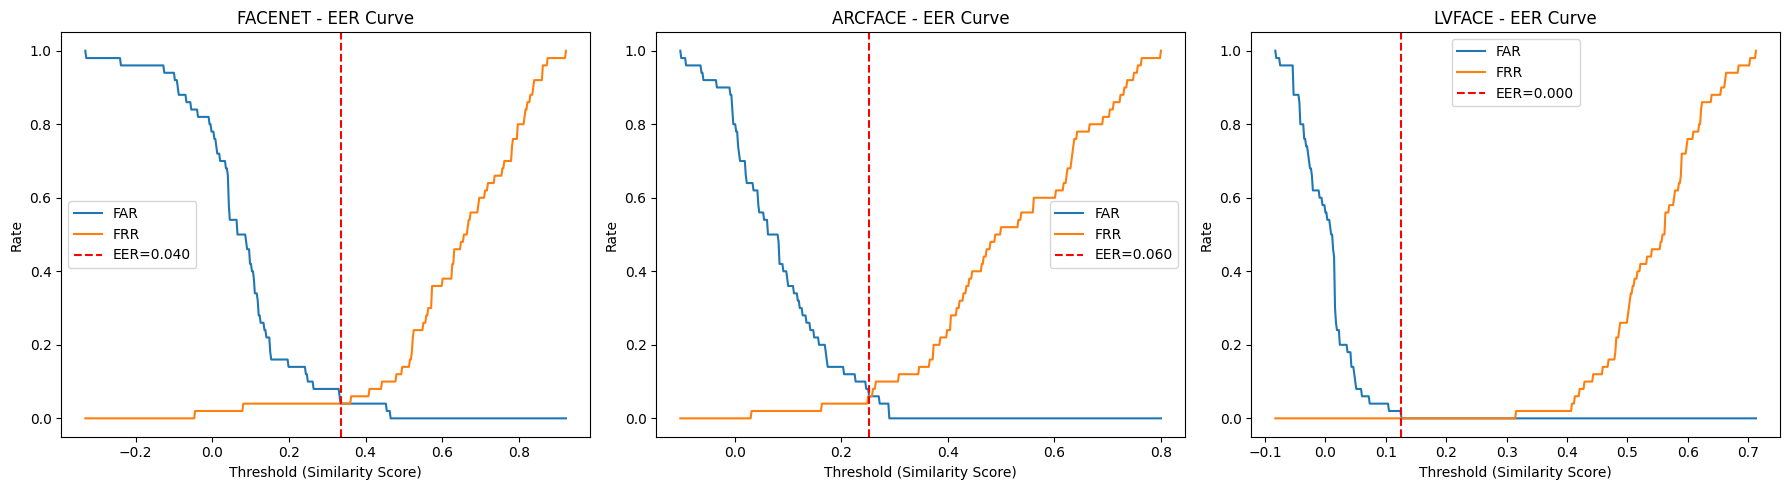

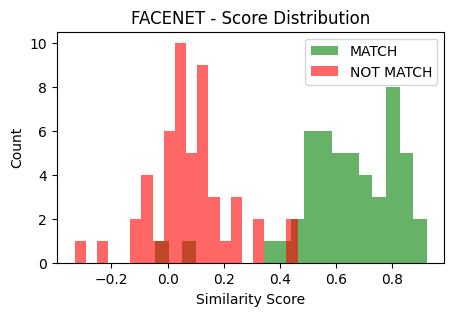

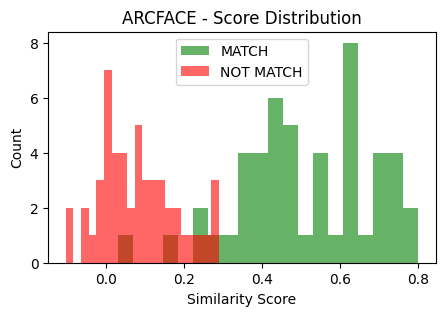

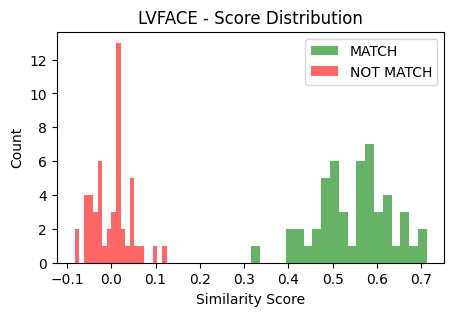


=== DEBUG SCORE RANGE ===
FACENET:
  MATCH mean: 0.6427
  NOT MATCH mean: 0.0778
  MATCH range: -0.0452 → 0.9234
  NOT MATCH range: -0.3316 → 0.4633

ARCFACE:
  MATCH mean: 0.5125
  NOT MATCH mean: 0.0804
  MATCH range: 0.0316 → 0.7999
  NOT MATCH range: -0.1021 → 0.2897

LVFACE:
  MATCH mean: 0.5473
  NOT MATCH mean: 0.0013
  MATCH range: 0.3153 → 0.7129
  NOT MATCH range: -0.0831 → 0.1249
  ⚠️ Perfect separation detected (tidak ada overlap, EER=0)


=== HASIL AKHIR (FAR, FRR, EER) ===
     Model   EER  Threshold_EER  FAR@EER  FRR@EER  \
0  FACENET  0.04         0.3349     0.04     0.04   
1  ARCFACE  0.06         0.2522     0.06     0.06   
2   LVFACE  0.00         0.1259     0.00     0.00   

                                  Note  
0                                       
1                                       
2  ⚠️ Perfect separation (EER=0 valid)  


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 1️⃣ Load dataset
# =========================
# Misal file CSV kamu sudah dibaca jadi DataFrame df
# Contoh: df = pd.read_csv("hasil_matching.csv")

# Pastikan kolom numerik
for col in ['facenet_score', 'arcface_score', 'lvface_score']:
    df2[col] = pd.to_numeric(df2[col], errors='coerce')

# =========================
# 2️⃣ Override label untuk Facenet & ArcFace (baris 1–50 = MATCH)
# =========================
df2['facenet_label'] = 0
df2.loc[:49, 'facenet_label'] = 1  # baris 1–50 dianggap MATCH

df2['arcface_label'] = 0
df2.loc[:49, 'arcface_label'] = 1  # baris 1–50 dianggap MATCH

# LVFace tidak diubah
# df['lvface_label'] tetap seperti aslinya

# =========================
# 3️⃣ Fungsi menghitung FAR, FRR, dan EER (Similarity-based)
# =========================
def compute_far_frr(scores, labels):
    """
    Menghitung FAR, FRR, dan EER untuk model similarity-based.
    Semakin besar score → semakin match.
    """
    eps = 1e-6
    thresholds = np.linspace(min(scores) - eps, max(scores) + eps, 500)
    fars, frrs = [], []

    total_neg = np.sum(labels == 0)  # NOT MATCH
    total_pos = np.sum(labels == 1)  # MATCH

    for th in thresholds:
        preds = (scores >= th).astype(int)  # similarity besar = MATCH
        fa = np.sum((preds == 1) & (labels == 0))  # False Accept
        fr = np.sum((preds == 0) & (labels == 1))  # False Reject

        fars.append(fa / total_neg if total_neg > 0 else 0)
        frrs.append(fr / total_pos if total_pos > 0 else 0)

    fars, frrs = np.array(fars), np.array(frrs)
    eer_idx = np.argmin(np.abs(fars - frrs))
    eer = (fars[eer_idx] + frrs[eer_idx]) / 2
    eer_thr = thresholds[eer_idx]

    return thresholds, fars, frrs, eer, eer_thr


# =========================
# 4️⃣ Loop tiap model
# =========================
models = {
    "facenet": ("facenet_score", "facenet_label"),
    "arcface": ("arcface_score", "arcface_label"),
    "lvface": ("lvface_score", "lvface_label"),
}

# Statistik dasar
print(df2[['facenet_score', 'arcface_score', 'lvface_score']].describe())
print("\nDistribusi label (setelah update):")
print("Facenet:", df2['facenet_label'].value_counts().to_dict())
print("ArcFace:", df2['arcface_label'].value_counts().to_dict())
print("LVFace:", df2['lvface_label'].value_counts().to_dict())

# =========================
# 5️⃣ Analisis per model + plot
# =========================
results = []
plt.figure(figsize=(18, 5))

for i, (name, (score_col, label_col)) in enumerate(models.items(), 1):
    scores = df2[score_col].values
    labels = df2[label_col].values

    thr, far, frr, eer, eer_thr = compute_far_frr(scores, labels)

    # Plot EER curve
    plt.subplot(1, 3, i)
    plt.plot(thr, far, label='FAR')
    plt.plot(thr, frr, label='FRR')
    plt.axvline(eer_thr, color='red', linestyle='--', label=f'EER={eer:.3f}')
    plt.xlabel('Threshold (Similarity Score)')
    plt.ylabel('Rate')
    plt.title(f'{name.upper()} - EER Curve')
    plt.legend()

    # Deteksi jika separability sempurna
    match_min = df2[df2[label_col] == 1][score_col].min()
    notmatch_max = df2[df2[label_col] == 0][score_col].max()
    if match_min > notmatch_max:
        note = "⚠️ Perfect separation (EER=0 valid)"
    else:
        note = ""

    results.append({
        "Model": name.upper(),
        "EER": round(eer, 4),
        "Threshold_EER": round(eer_thr, 4),
        "FAR@EER": round(far[np.argmin(np.abs(far - frr))], 4),
        "FRR@EER": round(frr[np.argmin(np.abs(far - frr))], 4),
        "Note": note
    })

plt.tight_layout()
plt.show()

# =========================
# 6️⃣ Histogram distribusi MATCH vs NOT MATCH
# =========================
for name, (score_col, label_col) in models.items():
    plt.figure(figsize=(5, 3))
    plt.hist(df2[df2[label_col] == 1][score_col], bins=20, alpha=0.6, label='MATCH', color='green')
    plt.hist(df2[df2[label_col] == 0][score_col], bins=20, alpha=0.6, label='NOT MATCH', color='red')
    plt.title(f"{name.upper()} - Score Distribution")
    plt.xlabel("Similarity Score")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

# =========================
# 7️⃣ Debug detail per model
# =========================
print("\n=== DEBUG SCORE RANGE ===")
for name, (score_col, label_col) in models.items():
    match_mean = df2[df2[label_col] == 1][score_col].mean()
    not_match_mean = df2[df2[label_col] == 0][score_col].mean()
    match_range = (
        df2[df2[label_col] == 1][score_col].min(),
        df2[df2[label_col] == 1][score_col].max()
    )
    not_match_range = (
        df2[df2[label_col] == 0][score_col].min(),
        df2[df2[label_col] == 0][score_col].max()
    )

    print(f"{name.upper()}:")
    print(f"  MATCH mean: {match_mean:.4f}")
    print(f"  NOT MATCH mean: {not_match_mean:.4f}")
    print(f"  MATCH range: {match_range[0]:.4f} → {match_range[1]:.4f}")
    print(f"  NOT MATCH range: {not_match_range[0]:.4f} → {not_match_range[1]:.4f}")
    if match_range[0] > not_match_range[1]:
        print("  ⚠️ Perfect separation detected (tidak ada overlap, EER=0)")
    print()

# =========================
# 8️⃣ Cetak hasil akhir
# =========================
result_df2 = pd.DataFrame(results)
print("\n=== HASIL AKHIR (FAR, FRR, EER) ===")
print(result_df2)


       facenet_score  arcface_score  lvface_score
count     100.000000     100.000000    100.000000
mean        0.397433       0.315477      0.258004
std         0.321684       0.267596      0.277860
min        -0.162500      -0.078400     -0.106400
25%         0.103625       0.084200     -0.003100
50%         0.391900       0.248450      0.071650
75%         0.696725       0.579425      0.537900
max         0.933000       0.900000      0.693300

Distribusi label (setelah update):
Facenet: {1: 50, 0: 50}
ArcFace: {1: 50, 0: 50}
LVFace: {0: 56, 1: 44}


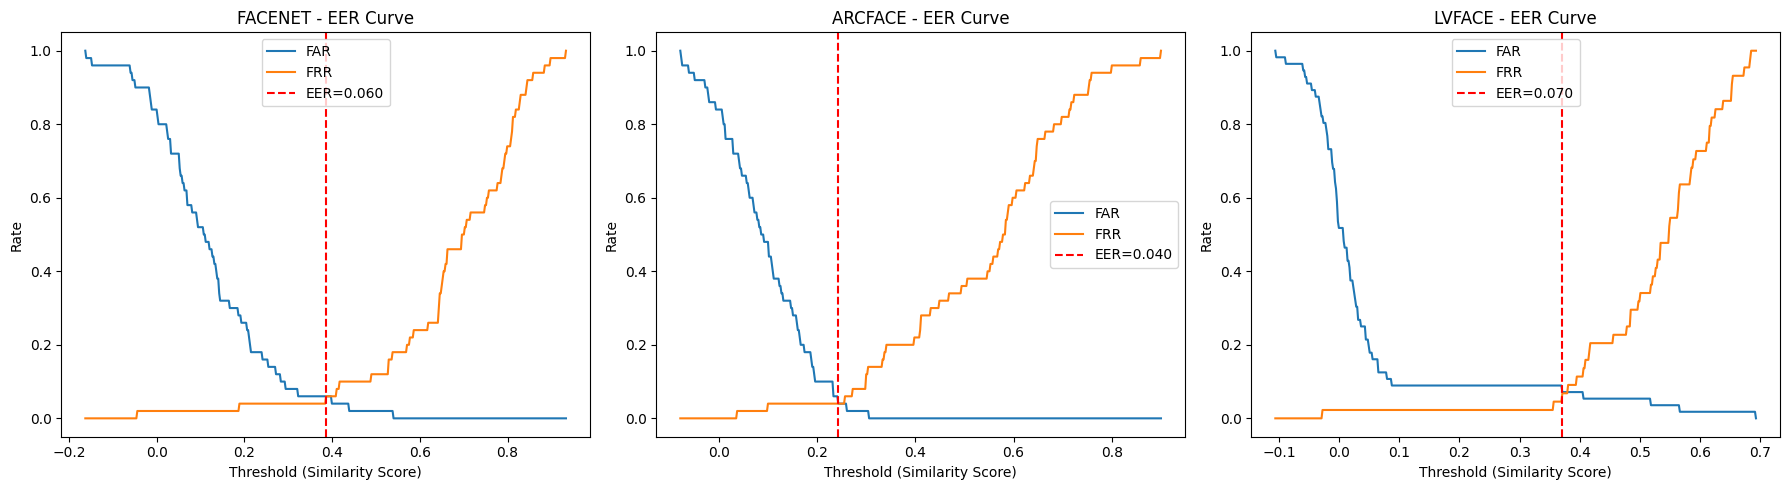

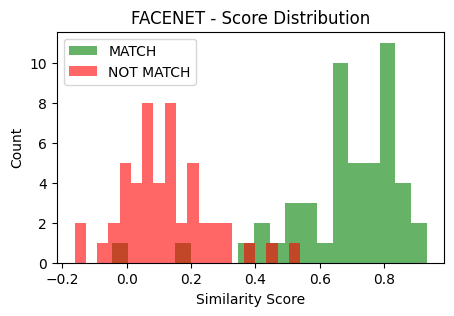

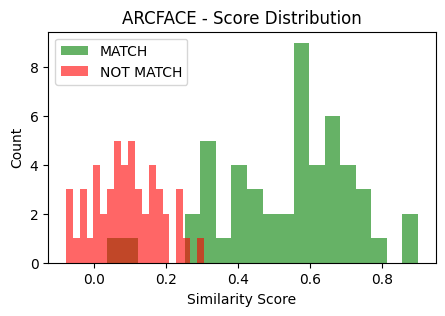

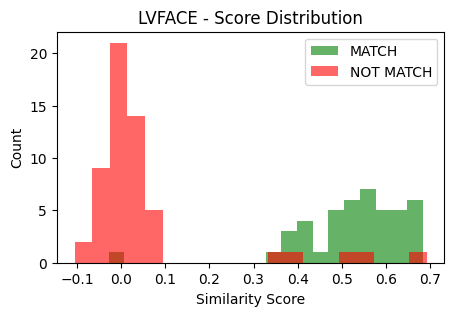


=== DEBUG SCORE RANGE ===
FACENET:
  MATCH mean: 0.6750
  NOT MATCH mean: 0.1199
  MATCH range: -0.0444 → 0.9330
  NOT MATCH range: -0.1625 → 0.5392

ARCFACE:
  MATCH mean: 0.5391
  NOT MATCH mean: 0.0919
  MATCH range: 0.0365 → 0.9000
  NOT MATCH range: -0.0784 → 0.3056

LVFACE:
  MATCH mean: 0.5263
  NOT MATCH mean: 0.0472
  MATCH range: -0.0287 → 0.6839
  NOT MATCH range: -0.1064 → 0.6933


=== HASIL AKHIR (FAR, FRR, EER) ===
     Model     EER  Threshold_EER  FAR@EER  FRR@EER Note
0  FACENET  0.0600         0.3863   0.0600   0.0600     
1  ARCFACE  0.0400         0.2432   0.0400   0.0400     
2   LVFACE  0.0698         0.3712   0.0714   0.0682     


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 1️⃣ Load dataset
# =========================
# Misal file CSV kamu sudah dibaca jadi DataFrame df
# Contoh: df = pd.read_csv("hasil_matching.csv")

# Pastikan kolom numerik
for col in ['facenet_score', 'arcface_score', 'lvface_score']:
    df3[col] = pd.to_numeric(df3[col], errors='coerce')

# =========================
# 2️⃣ Override label untuk Facenet & ArcFace (baris 1–50 = MATCH)
# =========================
df3['facenet_label'] = 0
df3.loc[:49, 'facenet_label'] = 1  # baris 1–50 dianggap MATCH

df3['arcface_label'] = 0
df3.loc[:49, 'arcface_label'] = 1  # baris 1–50 dianggap MATCH

# LVFace tidak diubah
# df['lvface_label'] tetap seperti aslinya

# =========================
# 3️⃣ Fungsi menghitung FAR, FRR, dan EER (Similarity-based)
# =========================
def compute_far_frr(scores, labels):
    """
    Menghitung FAR, FRR, dan EER untuk model similarity-based.
    Semakin besar score → semakin match.
    """
    eps = 1e-6
    thresholds = np.linspace(min(scores) - eps, max(scores) + eps, 500)
    fars, frrs = [], []

    total_neg = np.sum(labels == 0)  # NOT MATCH
    total_pos = np.sum(labels == 1)  # MATCH

    for th in thresholds:
        preds = (scores >= th).astype(int)  # similarity besar = MATCH
        fa = np.sum((preds == 1) & (labels == 0))  # False Accept
        fr = np.sum((preds == 0) & (labels == 1))  # False Reject

        fars.append(fa / total_neg if total_neg > 0 else 0)
        frrs.append(fr / total_pos if total_pos > 0 else 0)

    fars, frrs = np.array(fars), np.array(frrs)
    eer_idx = np.argmin(np.abs(fars - frrs))
    eer = (fars[eer_idx] + frrs[eer_idx]) / 2
    eer_thr = thresholds[eer_idx]

    return thresholds, fars, frrs, eer, eer_thr


# =========================
# 4️⃣ Loop tiap model
# =========================
models = {
    "facenet": ("facenet_score", "facenet_label"),
    "arcface": ("arcface_score", "arcface_label"),
    "lvface": ("lvface_score", "lvface_label"),
}

# Statistik dasar
print(df3[['facenet_score', 'arcface_score', 'lvface_score']].describe())
print("\nDistribusi label (setelah update):")
print("Facenet:", df3['facenet_label'].value_counts().to_dict())
print("ArcFace:", df3['arcface_label'].value_counts().to_dict())
print("LVFace:", df3['lvface_label'].value_counts().to_dict())

# =========================
# 5️⃣ Analisis per model + plot
# =========================
results = []
plt.figure(figsize=(18, 5))

for i, (name, (score_col, label_col)) in enumerate(models.items(), 1):
    scores = df3[score_col].values
    labels = df3[label_col].values

    thr, far, frr, eer, eer_thr = compute_far_frr(scores, labels)

    # Plot EER curve
    plt.subplot(1, 3, i)
    plt.plot(thr, far, label='FAR')
    plt.plot(thr, frr, label='FRR')
    plt.axvline(eer_thr, color='red', linestyle='--', label=f'EER={eer:.3f}')
    plt.xlabel('Threshold (Similarity Score)')
    plt.ylabel('Rate')
    plt.title(f'{name.upper()} - EER Curve')
    plt.legend()

    # Deteksi jika separability sempurna
    match_min = df3[df3[label_col] == 1][score_col].min()
    notmatch_max = df3[df3[label_col] == 0][score_col].max()
    if match_min > notmatch_max:
        note = "⚠️ Perfect separation (EER=0 valid)"
    else:
        note = ""

    results.append({
        "Model": name.upper(),
        "EER": round(eer, 4),
        "Threshold_EER": round(eer_thr, 4),
        "FAR@EER": round(far[np.argmin(np.abs(far - frr))], 4),
        "FRR@EER": round(frr[np.argmin(np.abs(far - frr))], 4),
        "Note": note
    })

plt.tight_layout()
plt.show()

# =========================
# 6️⃣ Histogram distribusi MATCH vs NOT MATCH
# =========================
for name, (score_col, label_col) in models.items():
    plt.figure(figsize=(5, 3))
    plt.hist(df3[df3[label_col] == 1][score_col], bins=20, alpha=0.6, label='MATCH', color='green')
    plt.hist(df3[df3[label_col] == 0][score_col], bins=20, alpha=0.6, label='NOT MATCH', color='red')
    plt.title(f"{name.upper()} - Score Distribution")
    plt.xlabel("Similarity Score")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

# =========================
# 7️⃣ Debug detail per model
# =========================
print("\n=== DEBUG SCORE RANGE ===")
for name, (score_col, label_col) in models.items():
    match_mean = df3[df3[label_col] == 1][score_col].mean()
    not_match_mean = df3[df3[label_col] == 0][score_col].mean()
    match_range = (
        df3[df3[label_col] == 1][score_col].min(),
        df3[df3[label_col] == 1][score_col].max()
    )
    not_match_range = (
        df3[df3[label_col] == 0][score_col].min(),
        df3[df3[label_col] == 0][score_col].max()
    )

    print(f"{name.upper()}:")
    print(f"  MATCH mean: {match_mean:.4f}")
    print(f"  NOT MATCH mean: {not_match_mean:.4f}")
    print(f"  MATCH range: {match_range[0]:.4f} → {match_range[1]:.4f}")
    print(f"  NOT MATCH range: {not_match_range[0]:.4f} → {not_match_range[1]:.4f}")
    if match_range[0] > not_match_range[1]:
        print("  ⚠️ Perfect separation detected (tidak ada overlap, EER=0)")
    print()

# =========================
# 8️⃣ Cetak hasil akhir
# =========================
result_df3 = pd.DataFrame(results)
print("\n=== HASIL AKHIR (FAR, FRR, EER) ===")
print(result_df3)


       facenet_score  arcface_score  lvface_score
count     100.000000     100.000000    100.000000
mean        0.435980       0.400234      0.327685
std         0.369983       0.352425      0.330348
min        -0.209200      -0.101400     -0.110000
25%         0.100075       0.074300      0.007600
50%         0.409450       0.346550      0.321900
75%         0.759200       0.645000      0.650900
max         0.999800       0.999400      0.781900

Distribusi label (setelah update):
Facenet: {1: 50, 0: 50}
ArcFace: {1: 50, 0: 50}
LVFace: {1: 50, 0: 50}


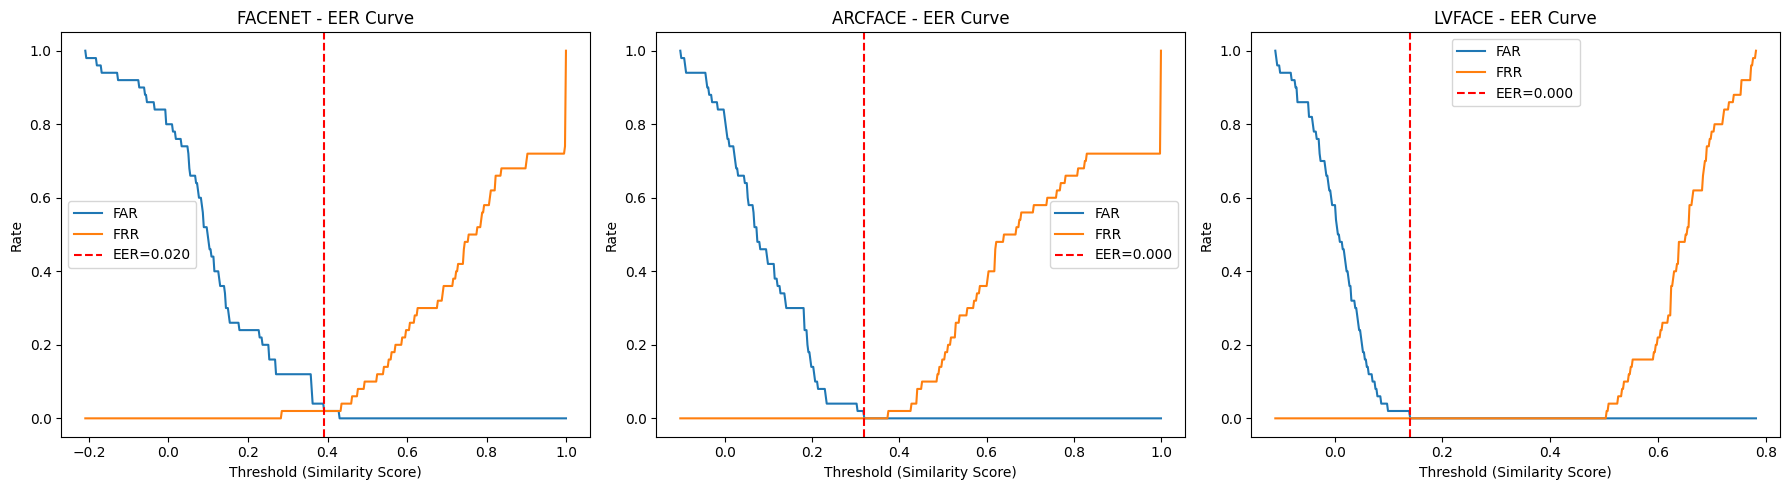

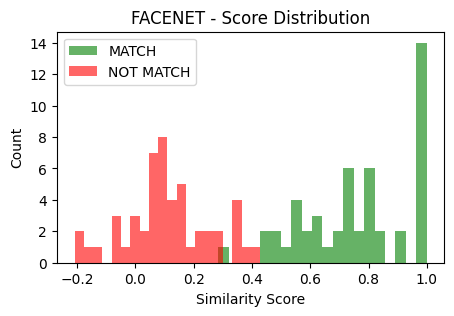

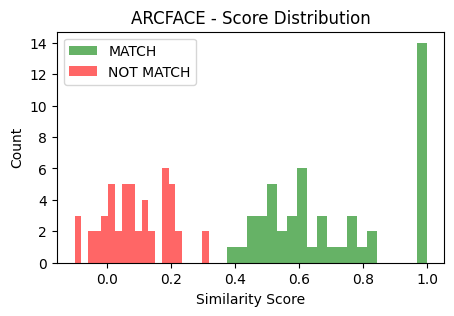

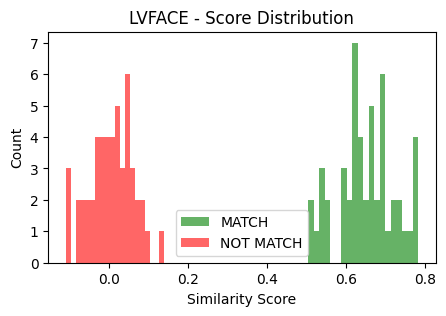


=== DEBUG SCORE RANGE ===
FACENET:
  MATCH mean: 0.7628
  NOT MATCH mean: 0.1091
  MATCH range: 0.2839 → 0.9998
  NOT MATCH range: -0.2092 → 0.4286

ARCFACE:
  MATCH mean: 0.7112
  NOT MATCH mean: 0.0893
  MATCH range: 0.3748 → 0.9994
  NOT MATCH range: -0.1014 → 0.3183
  ⚠️ Perfect separation detected (tidak ada overlap, EER=0)

LVFACE:
  MATCH mean: 0.6501
  NOT MATCH mean: 0.0052
  MATCH range: 0.5040 → 0.7819
  NOT MATCH range: -0.1100 → 0.1398
  ⚠️ Perfect separation detected (tidak ada overlap, EER=0)


=== HASIL AKHIR (FAR, FRR, EER) ===
     Model   EER  Threshold_EER  FAR@EER  FRR@EER  \
0  FACENET  0.02         0.3917     0.02     0.02   
1  ARCFACE  0.00         0.3199     0.00     0.00   
2   LVFACE  0.00         0.1402     0.00     0.00   

                                  Note  
0                                       
1  ⚠️ Perfect separation (EER=0 valid)  
2  ⚠️ Perfect separation (EER=0 valid)  


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 1️⃣ Load dataset
# =========================
# Misal file CSV kamu sudah dibaca jadi DataFrame df
# Contoh: df = pd.read_csv("hasil_matching.csv")

# Pastikan kolom numerik
for col in ['facenet_score', 'arcface_score', 'lvface_score']:
    df4[col] = pd.to_numeric(df4[col], errors='coerce')

# =========================
# 2️⃣ Override label untuk Facenet & ArcFace (baris 1–50 = MATCH)
# =========================
df4['facenet_label'] = 0
df4.loc[:49, 'facenet_label'] = 1  # baris 1–50 dianggap MATCH

df4['arcface_label'] = 0
df4.loc[:49, 'arcface_label'] = 1  # baris 1–50 dianggap MATCH

df4['lvface_label'] = 0
df4.loc[:49, 'lvface_label'] = 1  # baris 1–50 dianggap MATCH

# LVFace tidak diubah
# df['lvface_label'] tetap seperti aslinya

# =========================
# 3️⃣ Fungsi menghitung FAR, FRR, dan EER (Similarity-based)
# =========================
def compute_far_frr(scores, labels):
    """
    Menghitung FAR, FRR, dan EER untuk model similarity-based.
    Semakin besar score → semakin match.
    """
    eps = 1e-6
    thresholds = np.linspace(min(scores) - eps, max(scores) + eps, 500)
    fars, frrs = [], []

    total_neg = np.sum(labels == 0)  # NOT MATCH
    total_pos = np.sum(labels == 1)  # MATCH

    for th in thresholds:
        preds = (scores >= th).astype(int)  # similarity besar = MATCH
        fa = np.sum((preds == 1) & (labels == 0))  # False Accept
        fr = np.sum((preds == 0) & (labels == 1))  # False Reject

        fars.append(fa / total_neg if total_neg > 0 else 0)
        frrs.append(fr / total_pos if total_pos > 0 else 0)

    fars, frrs = np.array(fars), np.array(frrs)
    eer_idx = np.argmin(np.abs(fars - frrs))
    eer = (fars[eer_idx] + frrs[eer_idx]) / 2
    eer_thr = thresholds[eer_idx]

    return thresholds, fars, frrs, eer, eer_thr


# =========================
# 4️⃣ Loop tiap model
# =========================
models = {
    "facenet": ("facenet_score", "facenet_label"),
    "arcface": ("arcface_score", "arcface_label"),
    "lvface": ("lvface_score", "lvface_label"),
}

# Statistik dasar
print(df4[['facenet_score', 'arcface_score', 'lvface_score']].describe())
print("\nDistribusi label (setelah update):")
print("Facenet:", df4['facenet_label'].value_counts().to_dict())
print("ArcFace:", df4['arcface_label'].value_counts().to_dict())
print("LVFace:", df4['lvface_label'].value_counts().to_dict())

# =========================
# 5️⃣ Analisis per model + plot
# =========================
results = []
plt.figure(figsize=(18, 5))

for i, (name, (score_col, label_col)) in enumerate(models.items(), 1):
    scores = df4[score_col].values
    labels = df4[label_col].values

    thr, far, frr, eer, eer_thr = compute_far_frr(scores, labels)

    # Plot EER curve
    plt.subplot(1, 3, i)
    plt.plot(thr, far, label='FAR')
    plt.plot(thr, frr, label='FRR')
    plt.axvline(eer_thr, color='red', linestyle='--', label=f'EER={eer:.3f}')
    plt.xlabel('Threshold (Similarity Score)')
    plt.ylabel('Rate')
    plt.title(f'{name.upper()} - EER Curve')
    plt.legend()

    # Deteksi jika separability sempurna
    match_min = df4[df4[label_col] == 1][score_col].min()
    notmatch_max = df4[df4[label_col] == 0][score_col].max()
    if match_min > notmatch_max:
        note = "⚠️ Perfect separation (EER=0 valid)"
    else:
        note = ""

    results.append({
        "Model": name.upper(),
        "EER": round(eer, 4),
        "Threshold_EER": round(eer_thr, 4),
        "FAR@EER": round(far[np.argmin(np.abs(far - frr))], 4),
        "FRR@EER": round(frr[np.argmin(np.abs(far - frr))], 4),
        "Note": note
    })

plt.tight_layout()
plt.show()

# =========================
# 6️⃣ Histogram distribusi MATCH vs NOT MATCH
# =========================
for name, (score_col, label_col) in models.items():
    plt.figure(figsize=(5, 3))
    plt.hist(df4[df4[label_col] == 1][score_col], bins=20, alpha=0.6, label='MATCH', color='green')
    plt.hist(df4[df4[label_col] == 0][score_col], bins=20, alpha=0.6, label='NOT MATCH', color='red')
    plt.title(f"{name.upper()} - Score Distribution")
    plt.xlabel("Similarity Score")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

# =========================
# 7️⃣ Debug detail per model
# =========================
print("\n=== DEBUG SCORE RANGE ===")
for name, (score_col, label_col) in models.items():
    match_mean = df4[df4[label_col] == 1][score_col].mean()
    not_match_mean = df4[df4[label_col] == 0][score_col].mean()
    match_range = (
        df4[df4[label_col] == 1][score_col].min(),
        df4[df4[label_col] == 1][score_col].max()
    )
    not_match_range = (
        df4[df4[label_col] == 0][score_col].min(),
        df4[df4[label_col] == 0][score_col].max()
    )

    print(f"{name.upper()}:")
    print(f"  MATCH mean: {match_mean:.4f}")
    print(f"  NOT MATCH mean: {not_match_mean:.4f}")
    print(f"  MATCH range: {match_range[0]:.4f} → {match_range[1]:.4f}")
    print(f"  NOT MATCH range: {not_match_range[0]:.4f} → {not_match_range[1]:.4f}")
    if match_range[0] > not_match_range[1]:
        print("  ⚠️ Perfect separation detected (tidak ada overlap, EER=0)")
    print()

# =========================
# 8️⃣ Cetak hasil akhir
# =========================
result_df4 = pd.DataFrame(results)
print("\n=== HASIL AKHIR (FAR, FRR, EER) ===")
print(result_df4)
